# Prédiction d'une durée

Ce notebook cherche à prédire la durée de stockage de paquets préparés par un magasin. Chaque paquet met plus ou moins de temps à être préparé. Si la commande arrive le soir et ne peut être finie avant la fin de la journée, elle est reportée sur la journée suivante. C'est la particularité de ce jeu de données.

* L'heure de la commande est uniformément répartie sur la semaine et la journée.
* La durée suit une loi $\Gamma(3, 0.5)$.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Distribution gamma

In [2]:
%matplotlib inline

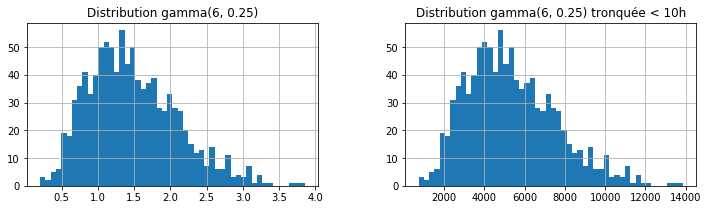

In [3]:
from numpy.random import gamma
g = gamma(6, 0.25, 1000)
mg = [min(_, 36000) for _ in (g * 3600)]

import matplotlib.pyplot as plt
import pandas
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
df = pandas.DataFrame(dict(g=g, mg=mg))
df.hist('g', bins=50, ax=ax[0])
df.hist('mg', bins=50, ax=ax[1])
ax[0].set_title('Distribution gamma(6, 0.25)')
ax[1].set_title('Distribution gamma(6, 0.25) tronquée < 10h');

On simule un jeu de données.

In [4]:
from papierstat.datasets import duration_selling
df = duration_selling()
df.head()

,commande,reception,true_duration
0,2017-04-03 16:43:19.283072,2017-04-03 17:45:07.767607,1.030135
1,2017-04-03 11:29:38.261222,2017-04-03 13:11:00.127606,1.689407
2,2017-04-03 18:57:44.125990,2017-04-04 10:54:13.042871,1.941366
3,2017-04-03 17:11:55.082596,2017-04-04 10:16:52.595326,3.082642
4,2017-04-03 11:52:00.812996,2017-04-03 14:08:45.604507,2.279109


In [5]:
df.shape

(2442, 3)

In [6]:
help(duration_selling)

Help on function duration_selling in module papierstat.datasets.duration:

duration_selling(date_begin=None, date_end=None, mean_per_day=10, sigma_per_day=5, week_pattern=None, hour_begin=9, hour_end=19, gamma_k=6.0, gamma_theta=0.25)
    Construit un jeu de données artificiel qui simule des paquets
    préparés par un magasin. Chaque paquet est préparé dès la réception
    d'une commande à une heure précise, il est ensuite stocké
    jusqu'à ce qu'un client viennent le chercher.
    
    @param      date_begin      première date
    @param      date_end        dernière date
    @param      hour_begin      heure d'ouverture du magasin
    @param      hour_end        heure de fermeture du magasin
    @param      week_pattern    tableau de 7 valeurs ou None
                                pour une distribution uniforme sur les jours
                                de la semaine
    @param      mean_per_day    nombre de paquets moyen par jour (suit une loi gaussienne)
    @param      sigm

## Quelques statistiques



In [7]:
stat = df.copy()
stat["wk"] = stat.commande.dt.weekday
stat["wk2"] = stat.reception.dt.weekday
stat["hr"] = stat.commande.dt.hour
stat["hr2"] = stat.reception.dt.hour

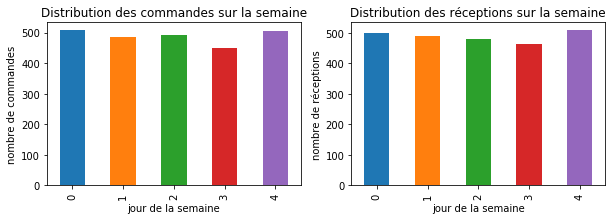

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
stat.groupby('wk').count()['commande'].plot(kind="bar", ax=ax[0])
ax[0].set_xlabel('jour de la semaine')
ax[0].set_ylabel('nombre de commandes')
ax[0].set_title("Distribution des commandes sur la semaine");
stat.groupby('wk2').count()['reception'].plot(kind="bar", ax=ax[1])
ax[1].set_xlabel('jour de la semaine')
ax[1].set_ylabel('nombre de réceptions')
ax[1].set_title("Distribution des réceptions sur la semaine");

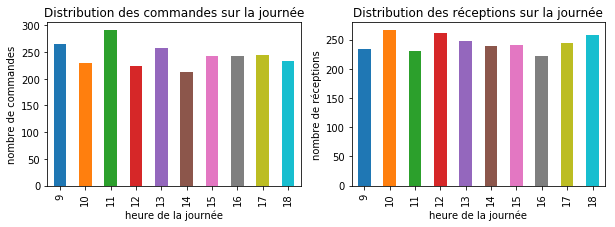

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
stat.groupby('hr').count()['commande'].plot(kind="bar", ax=ax[0])
ax[0].set_xlabel('heure de la journée')
ax[0].set_ylabel('nombre de commandes')
ax[0].set_title("Distribution des commandes sur la journée");
stat.groupby('hr2').count()['reception'].plot(kind="bar", ax=ax[1])
ax[1].set_xlabel('heure de la journée')
ax[1].set_ylabel('nombre de réceptions')
ax[1].set_title("Distribution des réceptions sur la journée");

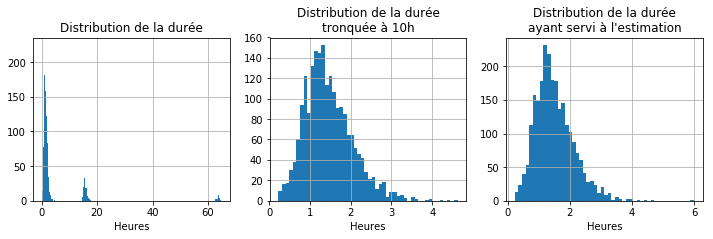

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
stat["duree"] = stat.reception - stat.commande
stat["seconds"] = stat.duree.dt.total_seconds() / 3600
stat['seconds'].hist(bins=500, ax=ax[0])
stat[stat.seconds < 10]['seconds'].hist(bins=50, ax=ax[1])
stat['true_duration'].hist(bins=50, ax=ax[2])
ax[0].set_title("Distribution de la durée")
ax[1].set_title("Distribution de la durée\ntronquée à 10h")
ax[2].set_title("Distribution de la durée\nayant servi à l'estimation")
ax[0].set_xlabel("Heures")
ax[1].set_xlabel("Heures")
ax[2].set_xlabel("Heures");

La distribution montre trois pics : le premier correspond aux paquets réceptionnés dans la journée, le second le lendemain et le troisième le week-end.

## Prédiction de la durée

Il n'y a pas grand-chose à prédire puisque tout est aléatoire excepté le fait que le fait qu'un paquet soit réceptionné le lendemain ou le lundi suivant. On construit donc une variable correspondant à l'heure de commande et le jour de la semaine. On compare un modèle linéaire et un arbre de décision.

### Comparaison d'un modèle linéaire et d'un arbre de précision

In [11]:
data = df.copy()
data["heure"] = data.commande.dt.hour + data.commande.dt.minute / 60
data["wk"] = data.commande.dt.weekday
data['duree'] = (data.reception - data.commande).dt.total_seconds() / 3600
data.head()

,commande,reception,true_duration,heure,wk,duree
0,2017-04-03 16:43:19.283072,2017-04-03 17:45:07.767607,1.030135,16.716667,0,1.030135
1,2017-04-03 11:29:38.261222,2017-04-03 13:11:00.127606,1.689407,11.483333,0,1.689407
2,2017-04-03 18:57:44.125990,2017-04-04 10:54:13.042871,1.941366,18.950000,0,15.941366
3,2017-04-03 17:11:55.082596,2017-04-04 10:16:52.595326,3.082642,17.183333,0,17.082642
4,2017-04-03 11:52:00.812996,2017-04-03 14:08:45.604507,2.279109,11.866667,0,2.279109


In [12]:
X = data[["heure", 'wk']]
y = data["duree"]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)
clr.score(X_test, y_test)

0.2285555207660247

In [15]:
from sklearn.tree import DecisionTreeRegressor
clr2 = DecisionTreeRegressor(max_depth=3)
clr2.fit(X_train, y_train)
clr2.score(X_test, y_test)

0.7114967666836103

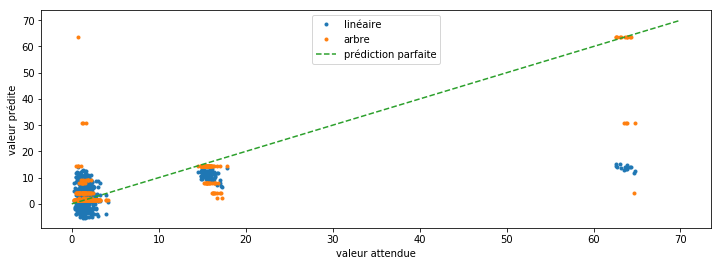

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(y_test, clr.predict(X_test), '.', label="linéaire")
ax.plot(y_test, clr2.predict(X_test), '.', label="arbre")
ax.plot([0,70], [0,70], '--', label="prédiction parfaite")
ax.set_xlabel("valeur attendue")
ax.set_ylabel("valeur prédite")
ax.legend();

L'arbre de décision est nettement meilleur simplement parce que la relation entre la valeur à prédire et les variables n'est pas linéaire.

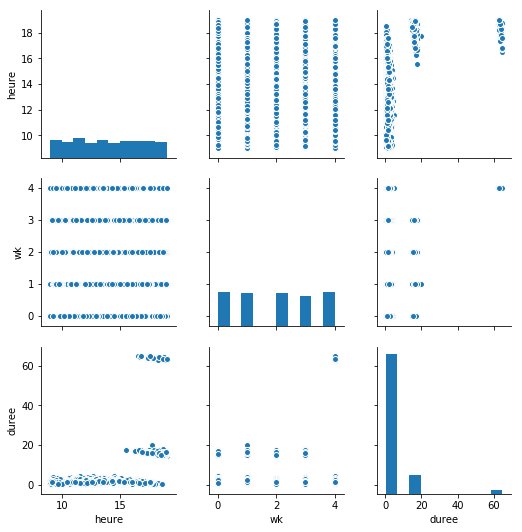

In [17]:
from seaborn import pairplot
xy = X.copy()
xy['duree'] = y
pairplot(xy);

In [18]:
from sklearn.tree import export_graphviz
dot = export_graphviz(clr2, out_file=None, feature_names=X.columns)
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

On voit bien que l'arbre de décision sépare le début et la fin de la journée. Après 17h30, la durée est augmentée de 8h en moyenne, si c'est vendredi, la durée est augmenté d'une vingtaine d'heure. Un modèle linéaire ne peut pas prendre cela en compte.

### Remarque sur le score R2

On voit que le score de prédiction $R^2$ est nettement meilleur pour l'arbre de décision mais c'est un petit peu en trompe l'oeil. La durée de la période d'inactivité joue un rôle non négligeable. Plus elle est longue, plus la durée entre la commande et la réception est grande en moyenne et c'est cette donnée que le modèle linéaire n'arrive pas à prendre en compte.

In [19]:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import numpy
res = []
for end in tqdm(range(1, 24)):
    scores_tree = []
    scores_lin = []
    for i in range(0, 5):
        df = duration_selling(hour_end=end, hour_begin=0, week_pattern=[1] * 7)
        data = df.copy()
        data["heure"] = data.commande.dt.hour + data.commande.dt.minute / 60
        data["wk"] = data.commande.dt.weekday
        data['duree'] = (data.reception - data.commande).dt.total_seconds() / 3600    
        X = data[["heure", 'wk']]
        y = data["duree"]
        clr = LinearRegression()
        clr2 = DecisionTreeRegressor(max_depth=3)
        score_tree = cross_val_score(clr2, X, y).mean()
        score_lin = cross_val_score(clr, X, y).mean()
        scores_tree.append(score_tree)
        scores_lin.append(score_lin)
    res.append(dict(end=end, score_tree=numpy.array(scores_tree).mean(),
                   score_lin=numpy.array(scores_lin).mean()))
res = pandas.DataFrame(res)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.36it/s]


c:\python364_x64\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


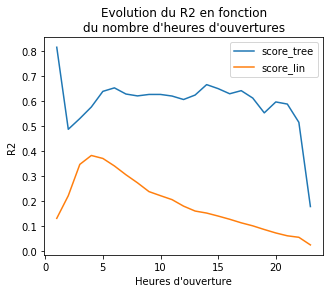

In [20]:
ax = res.plot(x='end', y=['score_tree', 'score_lin'], figsize=(5,4))
ax.set_title("Evolution du R2 en fonction\ndu nombre d'heures d'ouvertures")
ax.set_xlabel("Heures d'ouverture")
ax.set_ylabel("R2");

On voit que le $R^2$ pour l'arbre de décision et le modèle tendent vers 0 lorsque le nombre d'heures d'ouverture tend vers 24, cela signifie qu'il n'y a plus d'effets de seuil : la durée entre la réception et la commande suit une loi gamma et est complètement aléatoire. C'est attendue. A l'opposé, lorsque le nombre d'heure d'ouverture est très faible, la durée entre la commande et la réception est quasiment un mulitple de 24h puisque le magasin n'est quasiment jamais ouvert : l'arbre de décision est nettement meilleur dans ce cas. Le pic de $R^2$ est obtenu vers 4-5h d'ouvertures, cela correspond au moment où il n'y plus au pire qu'une seule nuit entre la réception et la commande.

Pour ce problème, le coefficient $R^2$ ne paraît pas être la bonne solution puisque de toute façon, le modèle prédit simplement si le paquet sera réceptionné le jour même ou le suivant. Ce serait plutôt un problème de classification binaire.